In [1]:
from tensorflow import keras

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

import librosa

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def extract_mel_spectrogram(audio, sr, n_mels=128,fmax=None):
    # Permite extraer el espectrograma mel de un dataset completo y guardarlo en una lista.
    mel_spectrogram=librosa.feature.melspectrogram(y=audio, sr=sr,
                                                   n_fft=2*1024, hop_length=512,
                                                   n_mels=n_mels,
                                                   fmax=fmax)
    mel_spectrogram_db=librosa.power_to_db(mel_spectrogram,ref=np.max)
    return mel_spectrogram_db


def scale_dataset(mel_list):
    scaler = StandardScaler()

    scaled_mel_list=[]
    for mel in mel_list:
        # primero aplanar para el scaler
        flattened_mel = mel.reshape(-1,1)
        # pasamos por el scaler
        mel_scaled= scaler.fit_transform(flattened_mel)
        # devolvemos la forma original
        flattened_mel=mel_scaled.reshape(mel.shape)
        # Aumentamos la forma para que encaje en como entrada en la red neuronal
        mel_scaled = np.expand_dims(flattened_mel, axis=-1)
        # Almacenamos en la lista
        scaled_mel_list.append(mel_scaled)

    # pasamos a array para la red neuronal
    scaled_mel_array = np.array(scaled_mel_list) 

    return scaled_mel_array

In [3]:
# Función de ajuste de etiquetas para realizar un ajuste fino y cambiar etiquetas incorrectas.
def ajustar_etiquetas(dataset_labels,to_landscape,to_plane,to_engine,to_voice):
    index=0
    truelabels=[]
    for label in dataset_labels:
        if index in to_landscape: # Cambiar a paisaje
            truelabels.append(0)
        elif index in to_plane: # Cambiar a avión
            truelabels.append(1)
        elif index in to_engine: # Cambiar a motor
            truelabels.append(2)
        elif index in to_voice: # Cambiar a voces 
            truelabels.append(3)
        else:
            truelabels.append(label)
        index+=1
    return truelabels

In [4]:
## Etiquetado manual del dataset inicial para 4 etiquetas
sample1=[0 for i in range(15)]
sample2=[0 for i in range(10)]
sample3=[1 for i in range(15)]
sample4=[1 for i in range(15)]
sample5=[2 for i in range(10)]
sample6=[2 for i in range(10)]
sample7=[2 for i in range(15)]
sample8=[3 for i in range(10)]
sample9=[3 for i in range(10)]

dataset1_labels=sample1+sample2+sample3+sample4+sample5+sample6+sample7+sample8+sample9

## ajuste de las etiquetas del dataset variado
to_landscape=[55,108,109]
to_plane=[]
to_engine=[]
to_voice=[75,76,77,82,83,86]

adjusted_truelabels=ajustar_etiquetas(dataset1_labels,to_landscape,to_plane,to_engine,to_voice)

In [5]:
# Crear y ajustar las etiquetas para las muestras 2 y 3
base_labes_1h=[0 for x in range(1200-1)]
len(base_labes_1h)

## cambios para la grabación nº2
to_landscape=[]
to_plane=[x for x in range(83,101)]+[x for x in range(303,324)]+[x for x in range(583,603)]+[x for x in range(914,927)]
to_engine=[x for x in range(24,49)]
to_voice=[]

adjusted_truelabels2=ajustar_etiquetas(base_labes_1h,to_landscape,to_plane,to_engine,to_voice)

## cambios para la grabación nº3
to_landscape=[]
to_plane=[x for x in range(361,379)]+[x for x in range(1143,1166)]
to_engine=[]
to_voice=[]

adjusted_truelabels3=ajustar_etiquetas(base_labes_1h,to_landscape,to_plane,to_engine,to_voice)

In [6]:
datasets_path="..\\data"
filename1="dataset_fase1.pkl"
filename2="SMA07415_20221113_073002.pkl"
filename3="SMA07415_20220608_082002.pkl"

filepath1=os.path.join(datasets_path,filename1)
filepath2=os.path.join(datasets_path,filename2)
filepath3=os.path.join(datasets_path,filename3)

test_dataset1=pd.read_pickle(filepath1) # Dataset variado
test_dataset2=pd.read_pickle(filepath2) # Aviones con paisaje acústico muy suave de fondo 
test_dataset3=pd.read_pickle(filepath3) # Aviones con paisaje acústico medio de fondo
sr=24000

In [7]:
# Calculo de espectrogramas mel
escalado=0
mel_list1 = []
for _, row in test_dataset1.iterrows():
    audio_fragment=row["Signal"]
    mel_S=extract_mel_spectrogram(audio_fragment,sr)
    mel_list1.append(mel_S)

if escalado==1:
    input_mel_array=scale_dataset(mel_list1)
    print("SE APLICA ESCALADO AL DATASET DE PRUEBAS")
if escalado==0:
    input_mel=np.expand_dims(mel_list1, axis=-1)
    input_mel_array1=np.array(input_mel)

mel_list2 = []
for _, row in test_dataset2.iterrows():
    audio_fragment=row["Signal"]
    mel_S=extract_mel_spectrogram(audio_fragment,sr)
    mel_list2.append(mel_S)

if escalado==1:
    input_mel_array=scale_dataset(mel_list2)
    print("SE APLICA ESCALADO AL DATASET DE PRUEBAS")
if escalado==0:
    input_mel=np.expand_dims(mel_list2, axis=-1)
    input_mel_array2=np.array(input_mel)

mel_list3 = []
for _, row in test_dataset3.iterrows():
    audio_fragment=row["Signal"]
    mel_S=extract_mel_spectrogram(audio_fragment,sr)
    mel_list3.append(mel_S)

if escalado==1:
    input_mel_array=scale_dataset(mel_list3)
    print("SE APLICA ESCALADO AL DATASET DE PRUEBAS")
if escalado==0:
    input_mel=np.expand_dims(mel_list3, axis=-1)
    input_mel_array3=np.array(input_mel)


In [8]:
hop_length=512
n_fft=2*1024
n_mels=128
fmax=None

test_signal1=np.concatenate(test_dataset1["Signal"])
S_Mel1 = librosa.feature.melspectrogram(y=test_signal1, sr=sr, n_fft=n_fft,hop_length=hop_length, n_mels=n_mels,fmax=fmax)
S_Log_Mel_dB1 = librosa.power_to_db(S_Mel1,ref=np.max)

test_signal2=np.concatenate(test_dataset2["Signal"])
S_Mel2 = librosa.feature.melspectrogram(y=test_signal2, sr=sr, n_fft=n_fft,hop_length=hop_length, n_mels=n_mels,fmax=fmax)
S_Log_Mel_dB2 = librosa.power_to_db(S_Mel2,ref=np.max)

test_signal3=np.concatenate(test_dataset3["Signal"])
S_Mel3 = librosa.feature.melspectrogram(y=test_signal3, sr=sr, n_fft=n_fft,hop_length=hop_length, n_mels=n_mels,fmax=fmax)
S_Log_Mel_dB3 = librosa.power_to_db(S_Mel3,ref=np.max)

In [9]:
name_model_list=["VGG11_b",
                 "VGG13_c",
                 "AlexNet_b",
                 "VGG16_b",
                 "ResNet50",
                 "VGG11_b_v2",
                 "VGG13_c_v2",
                 "AlexNet_b_v2",
                 "VGG16_b_v2",
                 "ResNet50_v2"]
nlabels=4

# Batería de pruebas aquí

Escoger uno de los modelos de la lista sustituyendo "N_Model" por el índice correspondiente

In [13]:
N_Model=6
name_model=name_model_list[N_Model]

model_path1=f"..\\models\\{name_model}.keras"
model_test = keras.models.load_model(model_path1, compile=False)
print(f"Modelo {name_model} cargado correctamente")

Modelo VGG13_c_v2 cargado correctamente


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step


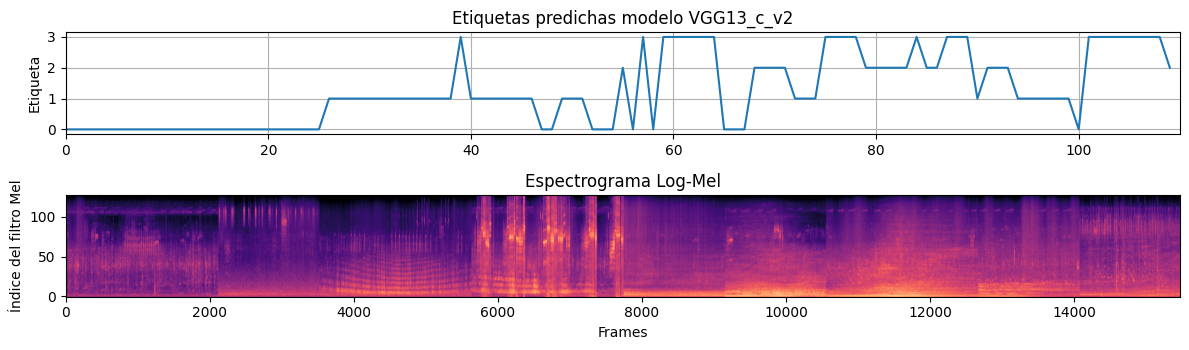

In [14]:
predictions_test = model_test.predict(input_mel_array1)
predicted_labels_test = np.argmax(predictions_test,axis=1)

fig, axis = plt.subplots(2,1,figsize=(12,4))
axis[0].plot(predicted_labels_test)
axis[0].set_title(f"Etiquetas predichas modelo {name_model}")
axis[0].set_ylabel("Etiqueta")
axis[0].set_yticks(np.arange(0, nlabels, 1))
axis[0].set_xlim([0,len(predicted_labels_test)])
axis[0].grid()

img2=plt.imshow(S_Log_Mel_dB1, aspect='auto', origin='lower', cmap='magma')
axis[1].set_title("Espectrograma Log-Mel")
axis[1].set_ylabel("Índice del filtro Mel")
axis[1].set_xlabel("Frames")

# Crear un nuevo axis para la colorbar horizontal
# cbar_axis = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
# cbar = fig.colorbar(img2, cax=cbar_axis, orientation="horizontal")
# cbar.set_label("Intensidad (dB)")

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

Modelo: VGG13_c_v2
Densidad de muestras con etiquetas 1, 2 y 3 respecto al total: 0.75
Predicción de muestras con etiquetas 1, 2 y 3 respecto al total: 0.66
Accuracy: 0.60
Precision: 0.58
Recall: 0.60
F1-score: 0.58

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77        28
           1       0.70      0.77      0.73        30
           2       0.50      0.29      0.36        28
           3       0.42      0.42      0.42        24

    accuracy                           0.60       110
   macro avg       0.57      0.59      0.57       110
weighted avg       0.58      0.60      0.58       110



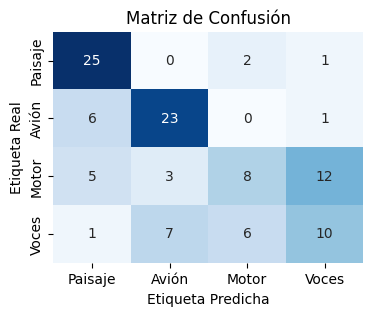

In [15]:

print(f"Modelo: {name_model}")

# Paso 1: Contar muestras con etiquetas 1, 2 y 3
muestras_123 = np.sum(np.isin(adjusted_truelabels, [1, 2, 3]))
densidad_123 = muestras_123 / len(adjusted_truelabels)
# Imprimir el resultado
print(f"Densidad de muestras con etiquetas 1, 2 y 3 respecto al total: {densidad_123:.2f}")
# Paso 2: Contar muestras con etiquetas 1, 2 y 3
muestras_123 = np.sum(np.isin(predicted_labels_test, [1, 2, 3]))
densidad_123 = muestras_123 / len(adjusted_truelabels)
# Imprimir el resultado
print(f"Predicción de muestras con etiquetas 1, 2 y 3 respecto al total: {densidad_123:.2f}")

# Calcula las métricas
accuracy = accuracy_score(adjusted_truelabels, predicted_labels_test)
precision = precision_score(adjusted_truelabels, predicted_labels_test, average='weighted')
recall = recall_score(adjusted_truelabels, predicted_labels_test, average='weighted')
f1 = f1_score(adjusted_truelabels, predicted_labels_test, average='weighted')

# Imprime las métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Genera el reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(adjusted_truelabels, predicted_labels_test))

# Genera la matriz de confusión
conf_matrix = confusion_matrix(adjusted_truelabels, predicted_labels_test)

# Visualiza la matriz de confusión
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Paisaje', 'Avión', 'Motor', 'Voces'],
            yticklabels=['Paisaje', 'Avión', 'Motor', 'Voces'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()


38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 370ms/step


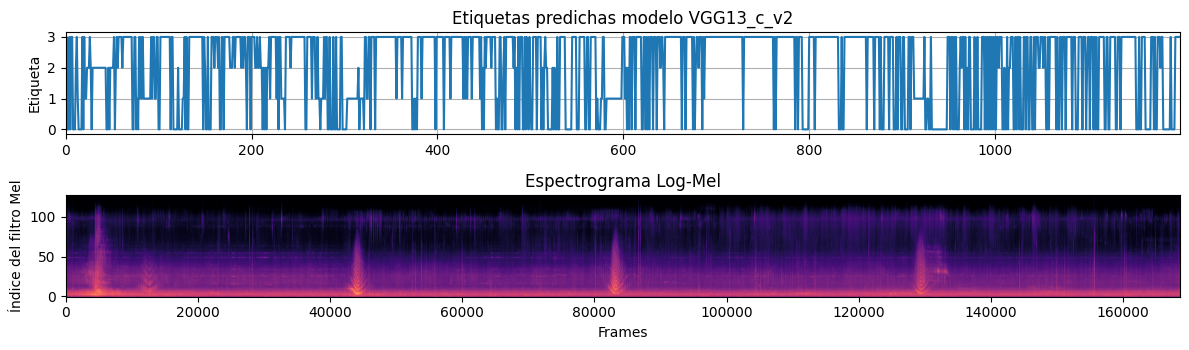

In [16]:
predictions_test = model_test.predict(input_mel_array2)
predicted_labels_test = np.argmax(predictions_test,axis=1)

fig, axis = plt.subplots(2,1,figsize=(12,4))
axis[0].plot(predicted_labels_test)
axis[0].set_title(f"Etiquetas predichas modelo {name_model}")
axis[0].set_ylabel("Etiqueta")
axis[0].set_yticks(np.arange(0, nlabels, 1))
axis[0].set_xlim([0,len(predicted_labels_test)])
axis[0].grid()

img2=plt.imshow(S_Log_Mel_dB2, aspect='auto', origin='lower', cmap='magma')
axis[1].set_title("Espectrograma Log-Mel")
axis[1].set_ylabel("Índice del filtro Mel")
axis[1].set_xlabel("Frames")

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

Modelo: VGG13_c_v2
Densidad de muestras con etiquetas 1, 2 y 3 respecto al total: 0.08
Predicción de muestras con etiquetas 1, 2 y 3 respecto al total: 0.75
Accuracy: 0.31
Precision: 0.93
Recall: 0.31
F1-score: 0.43

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.26      0.42      1102
           1       0.54      0.75      0.63        72
           2       0.24      0.80      0.37        25
           3       0.00      0.00      0.00         0

    accuracy                           0.31      1199
   macro avg       0.44      0.45      0.35      1199
weighted avg       0.93      0.31      0.43      1199



C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: Unde

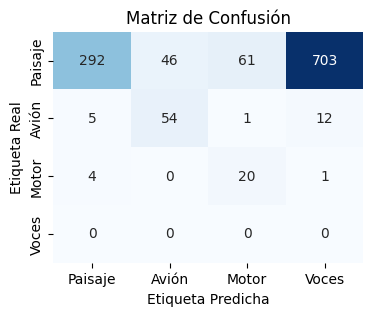

In [17]:
print(f"Modelo: {name_model}")

# Paso 1: Contar muestras con etiquetas 1, 2 y 3
muestras_123 = np.sum(np.isin(adjusted_truelabels2, [1, 2, 3]))
densidad_123 = muestras_123 / len(adjusted_truelabels2)
# Imprimir el resultado
print(f"Densidad de muestras con etiquetas 1, 2 y 3 respecto al total: {densidad_123:.2f}")
# Paso 2: Contar muestras con etiquetas 1, 2 y 3
muestras_123 = np.sum(np.isin(predicted_labels_test, [1, 2, 3]))
densidad_123 = muestras_123 / len(adjusted_truelabels2)
# Imprimir el resultado
print(f"Predicción de muestras con etiquetas 1, 2 y 3 respecto al total: {densidad_123:.2f}")


# Calcula las métricas
accuracy = accuracy_score(adjusted_truelabels2, predicted_labels_test)
precision = precision_score(adjusted_truelabels2, predicted_labels_test, average='weighted')
recall = recall_score(adjusted_truelabels2, predicted_labels_test, average='weighted')
f1 = f1_score(adjusted_truelabels2, predicted_labels_test, average='weighted')

# Imprime las métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Genera el reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(adjusted_truelabels2, predicted_labels_test))

# Genera la matriz de confusión
conf_matrix = confusion_matrix(adjusted_truelabels2, predicted_labels_test)

# Visualiza la matriz de confusión
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Paisaje', 'Avión', 'Motor', 'Voces'],
            yticklabels=['Paisaje', 'Avión', 'Motor', 'Voces'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 398ms/step


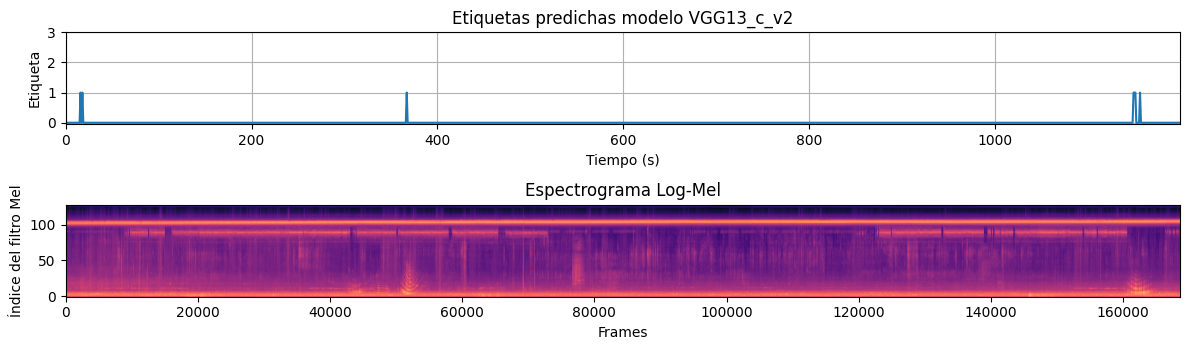

In [18]:
predictions_test = model_test.predict(input_mel_array3)
predicted_labels_test = np.argmax(predictions_test,axis=1)

fig, axis = plt.subplots(2,1,figsize=(12,4))
axis[0].plot(predicted_labels_test)
axis[0].set_title(f"Etiquetas predichas modelo {name_model}")
axis[0].set_ylabel("Etiqueta")
axis[0].set_xlabel("Tiempo (s)")
axis[0].set_yticks(np.arange(0, nlabels, 1))
axis[0].set_xlim([0,len(predicted_labels_test)])
axis[0].grid()

img2=plt.imshow(S_Log_Mel_dB3, aspect='auto', origin='lower', cmap='magma')
axis[1].set_title("Espectrograma Log-Mel")
axis[1].set_ylabel("Índice del filtro Mel")
axis[1].set_xlabel("Frames")

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

Modelo: VGG13_c_v2
Densidad de muestras con etiquetas 1, 2 y 3 respecto al total: 0.03
Predicción de muestras con etiquetas 1, 2 y 3 respecto al total: 0.01
Accuracy: 0.97
Precision: 0.96
Recall: 0.97
F1-score: 0.96

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1158
           1       0.71      0.12      0.21        41

    accuracy                           0.97      1199
   macro avg       0.84      0.56      0.60      1199
weighted avg       0.96      0.97      0.96      1199



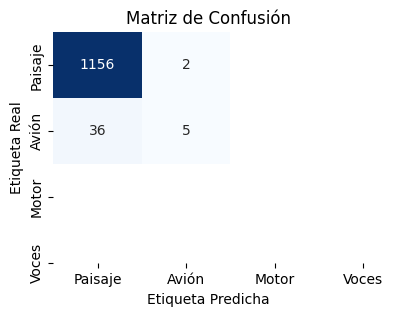

In [19]:
print(f"Modelo: {name_model}")

# Paso 1: Contar muestras con etiquetas 1, 2 y 3
muestras_123 = np.sum(np.isin(adjusted_truelabels3, [1, 2, 3]))
densidad_123 = muestras_123 / len(adjusted_truelabels3)
# Imprimir el resultado
print(f"Densidad de muestras con etiquetas 1, 2 y 3 respecto al total: {densidad_123:.2f}")
# Paso 2: Contar muestras con etiquetas 1, 2 y 3
muestras_123 = np.sum(np.isin(predicted_labels_test, [1, 2, 3]))
densidad_123 = muestras_123 / len(adjusted_truelabels2)
# Imprimir el resultado
print(f"Predicción de muestras con etiquetas 1, 2 y 3 respecto al total: {densidad_123:.2f}")
# Calcula las métricas
accuracy = accuracy_score(adjusted_truelabels3, predicted_labels_test)
precision = precision_score(adjusted_truelabels3, predicted_labels_test, average='weighted')
recall = recall_score(adjusted_truelabels3, predicted_labels_test, average='weighted')
f1 = f1_score(adjusted_truelabels3, predicted_labels_test, average='weighted')

# Imprime las métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Genera el reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(adjusted_truelabels3, predicted_labels_test))

# Genera la matriz de confusión
conf_matrix = confusion_matrix(adjusted_truelabels3, predicted_labels_test)

# Visualiza la matriz de confusión
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Paisaje', 'Avión', 'Motor', 'Voces'],
            yticklabels=['Paisaje', 'Avión', 'Motor', 'Voces'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()